In [1]:
# Dependencies
import requests
import json
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
# CovidActNow API Key
from config import api_key
# Census API Key
from config import census_key

In [2]:
# Create state population dataframe

# Specify the Census URL
census_url = "https://api.census.gov/data/2021/pep/population?"
# Build "Census Population By State" query URL
census_query_url = f"{census_url}get=DENSITY_2021,POP_2021,NAME,STATE&for=state:*&key={census_key}"

# Make state pops data request and save to a dataframe
pops_response = requests.get(census_query_url)
pops_json = pops_response.json()
row_counter = len(pops_json)
pops_data = []
for row in range(1, row_counter):
    pops_data.append(pops_json[row])
pops_data_df = pd.DataFrame(pops_data, columns = pops_json[0])

# Create new dataframe conatining only the needed data columns
reduced_pops_data_df = pops_data_df[["NAME", "POP_2021"]]

# Create a new dataframe that contains state name and ID
state_id = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY",
            "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH",
            "OK", "OR", "PA", "PR", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
state_list = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", 
              "District of Columbia", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas",
              "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi",
              "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", 
              "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", 
              "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", 
              "West Virginia", "Wisconsin", "Wyoming"]
state_id_df = pd.DataFrame({"NAME" : state_list,
                            "state" : state_id})

# Combine "pops_data_df" and "state_id_df" into a single dataframe
state_pops_data_df = pd.merge(state_id_df, reduced_pops_data_df, on = "NAME", how = "left", sort = False)

In [3]:
# Convert Population data type to float
state_pops_data_df["POP_2021"] = state_pops_data_df["POP_2021"].astype(float)
# Display preview of state population dataframe
state_pops_data_df.head()

,NAME,state,POP_2021
0,Alabama,AL,5039877.0
1,Alaska,AK,732673.0
2,Arizona,AZ,7276316.0
3,Arkansas,AR,3025891.0
4,California,CA,39237836.0


In [4]:
# Create Covid dataframe

# Specify the Covid URL
covid_url = "https://api.covidactnow.org/v2/states.timeseries.csv?apiKey="
# Build CovidActNow query URL
covid_query_url = f"{covid_url}{api_key}"

# Make Covid data request and save to a CSV file
covid_url_response = requests.get(covid_query_url)
covid_url_content = covid_url_response.content
csv_file = open('covid_data.csv', 'wb')
csv_file.write(covid_url_content)
csv_file.close()

# Path to the Covid data file
covid_data_path = "covid_data.csv"
# Read the CSV file and create a dataframe
covid_data_df = pd.read_csv(covid_data_path)

In [5]:
# Merge the "state_pops_data_df" and the "covid_data_df" into a single dataframe
covid_data_df = pd.merge(covid_data_df, state_pops_data_df, on = "state", how = "left", sort = False)

In [6]:
# Display preview of merged dataframe
covid_data_df.head()

,date,country,state,county,fips,lat,long,locationId,actuals.cases,actuals.deaths,...,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,actuals.newDeaths,actuals.vaccinesAdministered,riskLevels.caseDensity,cdcTransmissionLevel,actuals.vaccinationsAdditionalDose,metrics.vaccinationsAdditionalDoseRatio,NAME,POP_2021
0,2020-03-01,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Alaska,732673.0
1,2020-03-02,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Alaska,732673.0
2,2020-03-03,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Alaska,732673.0
3,2020-03-04,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Alaska,732673.0
4,2020-03-05,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Alaska,732673.0


In [7]:
# Create new dataframe with only the needed data columns and data for the target date range
clean_covid_df = covid_data_df[["date" , 
                                "state", 
                                "actuals.cases", 
                                "actuals.newCases", 
                                "actuals.deaths", 
                                "actuals.newDeaths", 
                                "actuals.positiveTests", 
                                "actuals.negativeTests",  
                                "actuals.hospitalBeds.capacity", 
                                "actuals.hospitalBeds.currentUsageCovid",
                                "actuals.icuBeds.capacity", 
                                "actuals.icuBeds.currentUsageCovid",
                                "actuals.vaccinesDistributed", 
                                "actuals.vaccinesAdministered",
                                "actuals.vaccinationsInitiated", 
                                "actuals.vaccinationsCompleted",  
                                "actuals.vaccinationsAdditionalDose",
                                "POP_2021"]]

# Rename columns for easier viewing
clean_covid_df = clean_covid_df.rename(columns={"date" : "Date", 
                                                "state" : "State", 
                                                "actuals.cases" : "Total_Cases",
                                                "actuals.newCases" : "New_Cases", 
                                                "actuals.deaths" : "Total_Deaths",
                                                "actuals.newDeaths" : "New_Deaths", 
                                                "actuals.positiveTests" : "Total_Positives",
                                                "actuals.negativeTests" : "Total_Negatives", 
                                                "actuals.hospitalBeds.capacity": "Total_Beds",
                                                "actuals.hospitalBeds.currentUsageCovid" : "Current_Bed",
                                                "actuals.icuBeds.capacity" : "Total_ICU", 
                                                "actuals.icuBeds.currentUsageCovid" : "Current_ICU",
                                                "actuals.vaccinesDistributed" : "Vaccine_Dist", 
                                                "actuals.vaccinesAdministered" : "Vaccine_Admin",
                                                "actuals.vaccinationsInitiated" : "Vaccine_Int", 
                                                "actuals.vaccinationsCompleted" : "Vaccine_Complete",
                                                "actuals.vaccinationsAdditionalDose" : "Add_Dose",
                                                "POP_2021" : "Population"})

# Filter for the data from 12/31/20 to most recent data
clean_covid_df = clean_covid_df.loc[(clean_covid_df["Date"] > "2020-12-30") &
                                    (clean_covid_df["Date"] < "2022-01-01"), :].reset_index(drop=True)

# Create "Year", "Month" and "Day" columns based on the "Date" column
clean_covid_df["Year"] = pd.DatetimeIndex(clean_covid_df["Date"]).year
clean_covid_df["Month"] = pd.DatetimeIndex(clean_covid_df["Date"]).month
clean_covid_df["Day"] = pd.DatetimeIndex(clean_covid_df["Date"]).day

# Move "Year", "Month" and "Day" columns to the front of the dataframe
year_column = clean_covid_df.pop("Year")
month_column = clean_covid_df.pop("Month")
day_column = clean_covid_df.pop("Day")
clean_covid_df.insert(0, "Year", year_column)
clean_covid_df.insert(1, "Month", month_column)
clean_covid_df.insert(2, "Day", day_column)

# Replace NaN values with 0
clean_covid_df = clean_covid_df.fillna(0)

In [8]:
# Display a preview of the "clean_covid_df" dataframe
clean_covid_df.head()

,Year,Month,Day,Date,State,Total_Cases,New_Cases,Total_Deaths,New_Deaths,Total_Positives,...,Total_Beds,Current_Bed,Total_ICU,Current_ICU,Vaccine_Dist,Vaccine_Admin,Vaccine_Int,Vaccine_Complete,Add_Dose,Population
0,2020,12,31,2020-12-31,AK,46740.0,499.0,198.0,3.0,84167.0,...,1642.0,80.0,127.0,10.0,54975.0,14550.0,0.0,0.0,0.0,732673.0
1,2021,1,1,2021-01-01,AK,46740.0,0.0,198.0,0.0,84423.0,...,1643.0,78.0,128.0,10.0,54975.0,16504.0,0.0,0.0,0.0,732673.0
2,2021,1,2,2021-01-02,AK,47549.0,809.0,207.0,9.0,84687.0,...,1641.0,88.0,127.0,11.0,54975.0,18401.0,0.0,0.0,0.0,732673.0
3,2021,1,3,2021-01-03,AK,47846.0,297.0,207.0,0.0,85010.0,...,1643.0,98.0,127.0,13.0,54975.0,18684.0,0.0,0.0,0.0,732673.0
4,2021,1,4,2021-01-04,AK,48110.0,264.0,209.0,2.0,85457.0,...,1447.0,86.0,127.0,16.0,75475.0,18937.0,0.0,0.0,0.0,732673.0


In [9]:
# Create the "final_monthly_set1_df" dataframe
monthly_set1_df = clean_covid_df[["State",
                                  "Year", 
                                  "Month", 
                                  "Day", 
                                  "Population",
                                  "Total_Cases", 
                                  "Total_Deaths", 
                                  "Total_Positives",
                                  "Total_Negatives", 
                                  "Vaccine_Dist",
                                  "Vaccine_Admin", 
                                  "Vaccine_Int",
                                  "Vaccine_Complete", 
                                  "Add_Dose"]]

# Sort the data using "State"(ascending), "Year"(ascending), "Month"(ascending)  and "Day" (descending) columns 
sorted_monthly_set1_df = monthly_set1_df.sort_values(by = ["State", "Year", "Month", "Day"], 
                                                     ascending = [True, True, True, False])

# Keep only the data for the last day of each month, remove all other days
final_monthly_set1_df = sorted_monthly_set1_df.drop_duplicates(subset = ["State", "Year", "Month"],
                                                               keep = "first").reset_index(drop=True)

# Define new columns to hold the monthly data values and state population
final_monthly_set1_df[["Monthly Cases", 
                       "Monthly Deaths", 
                       "Monthly Positive", 
                       "Monthly Negatives",
                       "Monthly Vaccine Initiated", 
                       "Monthly Vaccine Completed", 
                       "Monthly Additional Dose",
                       "Year-Month"]] = ""

# Calculate and populate the monthly data values 
row_counter = len(final_monthly_set1_df)
row_counter

for x in range(1, row_counter):
    final_monthly_set1_df.iloc[x, 14] = final_monthly_set1_df.iloc[x, 5] - final_monthly_set1_df.iloc[x-1, 5]
    final_monthly_set1_df.iloc[x, 15] = final_monthly_set1_df.iloc[x, 6] - final_monthly_set1_df.iloc[x-1, 6]
    final_monthly_set1_df.iloc[x, 16] = final_monthly_set1_df.iloc[x, 7] - final_monthly_set1_df.iloc[x-1, 7]
    final_monthly_set1_df.iloc[x, 17] = final_monthly_set1_df.iloc[x, 8] - final_monthly_set1_df.iloc[x-1, 8]
    final_monthly_set1_df.iloc[x, 18] = final_monthly_set1_df.iloc[x, 11] - final_monthly_set1_df.iloc[x-1, 11]
    final_monthly_set1_df.iloc[x, 19] = final_monthly_set1_df.iloc[x, 12] - final_monthly_set1_df.iloc[x-1, 12]
    final_monthly_set1_df.iloc[x, 20] = final_monthly_set1_df.iloc[x, 13] - final_monthly_set1_df.iloc[x-1, 13]
    final_monthly_set1_df.iloc[x, 21] = f"{final_monthly_set1_df.iloc[x, 1]}-{final_monthly_set1_df.iloc[x, 2]}"

# Clean up dataframe for easy viewing
# Remove all rows containing 12/31/2020 data
final_monthly_set1_df = final_monthly_set1_df.loc[final_monthly_set1_df["Year"] != 2020, :]

# Remove all columns that are not needed
final_monthly_set1_df = final_monthly_set1_df.drop(columns = ["Year","Month", "Day"])

# Move the "Month-Year" column after the state ID
year_month = final_monthly_set1_df.pop("Year-Month")
final_monthly_set1_df.insert(1, "Year-Month", year_month)

In [10]:
# Display preview of the "final_monthly_set1_df" dataframe
final_monthly_set1_df

,State,Year-Month,Population,Total_Cases,Total_Deaths,Total_Positives,Total_Negatives,Vaccine_Dist,Vaccine_Admin,Vaccine_Int,Vaccine_Complete,Add_Dose,Monthly Cases,Monthly Deaths,Monthly Positive,Monthly Negatives,Monthly Vaccine Initiated,Monthly Vaccine Completed,Monthly Additional Dose
1,AK,2021-1,732673.0,53985.0,253.0,93699.0,1547506.0,193150.0,119590.0,0.0,0.0,0.0,7245.0,55.0,9532.0,226096.0,0.0,0.0,0.0
2,AK,2021-2,732673.0,57846.0,279.0,98919.0,1742031.0,342535.0,264741.0,166735.0,0.0,0.0,3861.0,26.0,5220.0,194525.0,166735.0,0.0,0.0
3,AK,2021-3,732673.0,62559.0,299.0,104247.0,1954197.0,601225.0,407233.0,248711.0,163100.0,0.0,4713.0,20.0,5328.0,212166.0,81976.0,163100.0,0.0
4,AK,2021-4,732673.0,67598.0,330.0,109932.0,2152524.0,769205.0,552792.0,305395.0,256564.0,0.0,5039.0,31.0,5685.0,198327.0,56684.0,93464.0,0.0
5,AK,2021-5,732673.0,69627.0,352.0,112288.0,2299052.0,806335.0,612275.0,337795.0,287850.0,0.0,2029.0,22.0,2356.0,146528.0,32400.0,31286.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,WY,2021-8,578803.0,75136.0,858.0,62119.0,865487.0,586155.0,478281.0,262132.0,223590.0,0.0,10009.0,82.0,6378.0,59414.0,20522.0,11360.0,0.0
685,WY,2021-9,578803.0,90602.0,996.0,72700.0,949582.0,658215.0,520777.0,280635.0,240814.0,0.0,15466.0,138.0,10581.0,84095.0,18503.0,17224.0,0.0
686,WY,2021-10,578803.0,102926.0,1174.0,80967.0,1018073.0,742965.0,569168.0,294284.0,254028.0,30404.0,12324.0,178.0,8267.0,68491.0,13649.0,13214.0,30404.0
687,WY,2021-11,578803.0,111089.0,1428.0,85935.0,1076924.0,813665.0,632809.0,310481.0,263763.0,69165.0,8163.0,254.0,4968.0,58851.0,16197.0,9735.0,38761.0


In [11]:
# Export dataframe to csv file
final_monthly_set1_df.to_csv("Updated_Final_COVID_Data.csv")

In [12]:
# Create the "final_monthly_set2_df" dataframe

# Create a new dataFrame by removing the states with missing or incomplete data.
remove_list = ["ID", 
               "MP", 
               "NH", 
               "UT", 
               "WA"]
filtered_data_df = clean_covid_df[["Year", 
                                   "Month", 
                                   "State", 
                                   "Total_Beds", 
                                   "Current_Bed", 
                                   "Total_ICU", 
                                   "Current_ICU"]]
for remove in remove_list:
    filtered_data_df = filtered_data_df.loc[filtered_data_df["State"] != remove, :]
    
# Remove all rows containing data from 2020
filtered_data_df = filtered_data_df.loc[(filtered_data_df["Year"] != 2020), :].reset_index(drop = True)
# Group the data by "Year" and "Month" columns  
hospital_monthly_data = filtered_data_df.groupby(["Year", "Month"])
# Create a new dataframe containing the mean values based on the grouping above
monthly_set2_df = hospital_monthly_data.mean()
# Reset the index column
monthly_set2_df = monthly_set2_df.reset_index(drop=False)
# Insert new columns that will hold the calculated data, and the month-year values
monthly_set2_df[["%_Beds Used_By_Covid", 
                 "%_ICU_Beds Used_By_Covid", 
                 "Year_Month"]] = ""

# Calculate and populate the values for the "%_Beds Used_By_Covid", "%_ICU_Beds Used_By_Covid" 
# and "Year_Month" columns
row_count = len(monthly_set2_df)

for month_row in range(row_count):
    monthly_set2_df.iloc[month_row, 6] = 100*monthly_set2_df.iloc[month_row, 3]/monthly_set2_df.iloc[month_row, 2]
    monthly_set2_df.iloc[month_row, 7] = 100*monthly_set2_df.iloc[month_row, 5]/monthly_set2_df.iloc[month_row, 4]
    monthly_set2_df.iloc[month_row, 8] = f"{monthly_set2_df.iloc[month_row, 0]}-{monthly_set2_df.iloc[month_row, 1]}"

# Clean up the dataframe for easy viewing
monthly_set2_df = monthly_set2_df.drop(columns = ["Year", "Month"])
year_month = monthly_set2_df.pop("Year_Month")
monthly_set2_df.insert(0, "Year-Month", year_month)

# Create a new dataframe to hold the monthly vaccine data
temp_df = final_monthly_set1_df[["Year-Month", 
                                 "Population", 
                                 "Vaccine_Int", 
                                 "Vaccine_Complete", 
                                 "Add_Dose"]]

# Group the data by the "Year-Month" column
temp_data = temp_df.groupby("Year-Month")
# Create a new dataframe conataining the sum of the values based on the grouping above
temp_df2 = temp_data.sum()
# Reset the index column
temp_df2 = temp_df2.reset_index(drop=False)
# Insert new columns that will hold the calculated data
temp_df2[["%_Pops w/ 1_Vaccine_Shot", 
          "%_Pops w/ 2_Vaccine_Shots", 
          "%_Pops w/ Booster_Shot"]] = ""   

# Populate the values for the "%_Pops w/ 1_Vaccine_Shot", "%_Pops w/ 2_Vaccine_Shots"
# and "%_Pops w/ Booster_Shot" columns
row_count = len(temp_df2)

for month_row in range(row_count):
    try:
        temp_df2.iloc[month_row, 5] = 100*temp_df2.iloc[month_row, 2]/temp_df2.iloc[month_row, 1]
    except TypeError:
        temp_df2.iloc[month_row, 5] = 0
    try:
        temp_df2.iloc[month_row, 6] = 100*temp_df2.iloc[month_row, 3]/temp_df2.iloc[month_row, 1]
    except TypeError:
        temp_df2.iloc[month_row, 6] = 0
    try:
        temp_df2.iloc[month_row, 7] = 100*temp_df2.iloc[month_row, 4]/temp_df2.iloc[month_row, 1]
    except TypeError:
        temp_df2.iloc[month_row, 7] = 0 
        
# Merge the "monthly_set2_df" and "temp_df2" into a single dataframe
final_monthly_set2_df = pd.merge(monthly_set2_df, temp_df2, on = "Year-Month", how = "left", sort = False)

# Clean up the dataframe for easy viewing
final_monthly_set2_df = final_monthly_set2_df[["Year-Month",
                                               "Population",
                                               "Total_Beds",
                                               "Current_Bed", 
                                               "%_Beds Used_By_Covid",
                                               "Total_ICU",
                                               "Current_ICU", 
                                               "%_ICU_Beds Used_By_Covid",
                                               "Vaccine_Int",
                                               "Vaccine_Complete", 
                                               "Add_Dose", "%_Pops w/ 1_Vaccine_Shot",
                                               "%_Pops w/ 2_Vaccine_Shots", 
                                               "%_Pops w/ Booster_Shot"]]

# Rename some of the year-month data
final_monthly_set2_df["Year-Month"] = final_monthly_set2_df["Year-Month"].replace(
    {"2021-1": "2021-01",
     "2021-2": "2021-02",
     "2021-3": "2021-03",
     "2021-4": "2021-04",
     "2021-5": "2021-05",
     "2021-6": "2021-06",
     "2021-7": "2021-07",
     "2021-8": "2021-08",
     "2021-9": "2021-09",})

In [13]:
# Display a preview the "final_monthly_set2_df" dataframe
final_monthly_set2_df.head()

,Year-Month,Population,Total_Beds,Current_Bed,%_Beds Used_By_Covid,Total_ICU,Current_ICU,%_ICU_Beds Used_By_Covid,Vaccine_Int,Vaccine_Complete,Add_Dose,%_Pops w/ 1_Vaccine_Shot,%_Pops w/ 2_Vaccine_Shots,%_Pops w/ Booster_Shot
0,2021-01,335157329.0,16098.429435,2584.549059,16.054666,1839.246640,549.413306,29.871649,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-02,335157329.0,15917.453125,1493.985119,9.38583,1802.876488,338.375744,18.768659,46912926.0,0.0,0.0,13.997285,0.0,0.0
2,2021-03,335157329.0,15797.963710,867.706317,5.49252,1763.849462,185.202285,10.499892,92195193.0,51512250.0,0.0,27.508034,15.369573,0.0
3,2021-04,335157329.0,15834.748611,894.816667,5.650969,1751.950000,189.279861,10.803953,137021200.0,95985880.0,0.0,40.882651,28.639051,0.0
4,2021-05,335157329.0,15726.831989,645.010081,4.101335,1736.237231,149.063844,8.585454,159306707.0,128458244.0,0.0,47.531918,38.327744,0.0


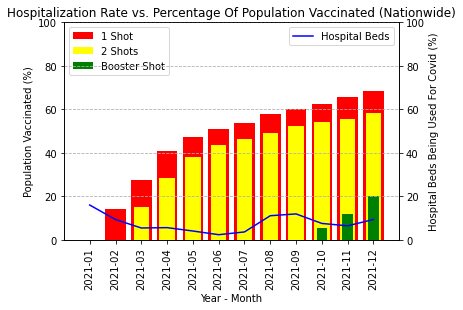

In [14]:
# Create a line and bar chart based on the % hospital beds used by covid and % of people vaccinated
fig, ax1 = plt.subplots()
plt.rcParams["figure.figsize"]=[10,6]
ax1.set_xlabel("Year - Month")
ax1.tick_params(axis = "x", labelrotation = 90)
ax1.set_ylabel("Population Vaccinated (%)")
ax1.bar(final_monthly_set2_df["Year-Month"], final_monthly_set2_df["%_Pops w/ 1_Vaccine_Shot"], color = "red",
        label = "1 Shot", width= 0.8)
ax1.bar(final_monthly_set2_df["Year-Month"], final_monthly_set2_df["%_Pops w/ 2_Vaccine_Shots"], color = "yellow",
        label = "2 Shots", width= 0.6)
ax1.bar(final_monthly_set2_df["Year-Month"], final_monthly_set2_df["%_Pops w/ Booster_Shot"], color = "green",
        label = "Booster Shot", width= 0.4)
ax1.set_ylim([0, 100])
ax1.legend(loc = "upper left")

ax2 = ax1.twinx()
ax2.plot(final_monthly_set2_df["Year-Month"], final_monthly_set2_df["%_Beds Used_By_Covid"], color = "blue", 
         label = "Hospital Beds")
ax2.set_ylabel("Hospital Beds Being Used For Covid (%)")
ax2.set_ylim([0, 100])
ax2.legend(loc = "upper right")
plt.grid(linestyle = '--')
plt.title("Hospitalization Rate vs. Percentage Of Population Vaccinated (Nationwide)")
plt.savefig("Images/HospitalBeds_vs_PerVaccinated.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ="b",
            orientation ="landscape")
plt.show()

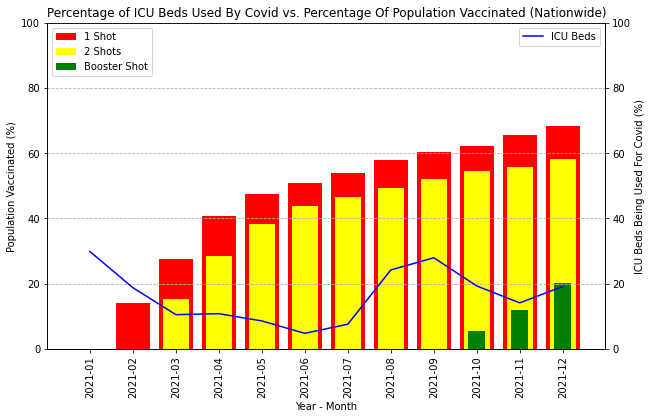

In [15]:
# Create a line and bar chart based on the % hospital ICU beds used by covid and % of people vaccinated
fig, ax1 = plt.subplots()
plt.rcParams["figure.figsize"]=[10,6]
ax1.set_xlabel("Year - Month")
ax1.tick_params(axis = "x", labelrotation = 90)
ax1.set_ylabel("Population Vaccinated (%)")
ax1.bar(final_monthly_set2_df["Year-Month"], final_monthly_set2_df["%_Pops w/ 1_Vaccine_Shot"], color = "red",
        label = "1 Shot", width= 0.8)
ax1.bar(final_monthly_set2_df["Year-Month"], final_monthly_set2_df["%_Pops w/ 2_Vaccine_Shots"], color = "yellow",
        label = "2 Shots", width= 0.6)
ax1.bar(final_monthly_set2_df["Year-Month"], final_monthly_set2_df["%_Pops w/ Booster_Shot"], color = "green",
        label = "Booster Shot", width= 0.4)
ax1.set_ylim([0, 100])
ax1.legend(loc = "upper left")

ax2 = ax1.twinx()
ax2.plot(final_monthly_set2_df["Year-Month"], final_monthly_set2_df["%_ICU_Beds Used_By_Covid"], color = "blue",
         label = "ICU Beds")
ax2.set_ylabel("ICU Beds Being Used For Covid (%)")
ax2.set_ylim([0, 100])
ax2.legend(loc = "upper right")
plt.grid(linestyle = '--')
plt.title("Percentage of ICU Beds Used By Covid vs. Percentage Of Population Vaccinated (Nationwide)")
plt.savefig("Images/ICUbeds_vs_PerVaccinated.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ="b",
            orientation ="landscape")
plt.show()

In [16]:
# Create the "final_monthly_set3_df" dataframe

# Create a dataframe that contains the monthly Covid cases and death counts pulled from "final_monthly_set1_df"
temp_df3 = final_monthly_set1_df[["Year-Month", 
                                 "Monthly Cases", 
                                 "Monthly Deaths"]]

# Remove the states with missing or incomplete data.
for remove in remove_list:
    temp_df3 = temp_df3.loc[filtered_data_df["State"] != remove, :]

# Group data by the "Year-Month" column
monthly_set3 = temp_df3.groupby("Year-Month")
# Create a new dataframe conataining the mean values based on the grouping above
monthly_set3_df = monthly_set3.sum()
# Reset the index column
monthly_set3_df = monthly_set3_df.reset_index(drop=False)
# Rename some of the year-month data
monthly_set3_df["Year-Month"] = monthly_set3_df["Year-Month"].replace({"2021-1": "2021-01",
                                                                       "2021-2": "2021-02",
                                                                       "2021-3": "2021-03",
                                                                       "2021-4": "2021-04",
                                                                       "2021-5": "2021-05",
                                                                       "2021-6": "2021-06",
                                                                       "2021-7": "2021-07",
                                                                       "2021-8": "2021-08",
                                                                       "2021-9": "2021-09",})
# Sort using the "Year-Month" column
monthly_set3_df = monthly_set3_df.sort_values("Year-Month")
# Reset the index column
monthly_set3_df = monthly_set3_df.reset_index(drop=False)
# Create a dataframe that contains the % vaccinated information pulled from "final_monthly_set2_df"
temp_df4 = final_monthly_set2_df[["Year-Month",
                                  "%_Pops w/ 1_Vaccine_Shot",
                                  "%_Pops w/ 2_Vaccine_Shots",
                                  "%_Pops w/ Booster_Shot"]]

# Merge "monthly_set3_df" and "temp_df4" into a single dataframe
final_monthly_set3_df = pd.merge(monthly_set3_df, temp_df4, on = "Year-Month", how = "left", sort = False)

In [17]:
# Display a preview the "final_monthly_set3_df" dataframe
final_monthly_set3_df.head()

,index,Year-Month,Monthly Cases,Monthly Deaths,%_Pops w/ 1_Vaccine_Shot,%_Pops w/ 2_Vaccine_Shots,%_Pops w/ Booster_Shot
0,0,2021-01,6174618.0,95241.0,0.0,0.0,0.0
1,4,2021-02,2393887.0,71677.0,13.997285,0.0,0.0
2,5,2021-03,1844959.0,38675.0,27.508034,15.369573,0.0
3,6,2021-04,1876030.0,23976.0,40.882651,28.639051,0.0
4,7,2021-05,910671.0,18681.0,47.531918,38.327744,0.0


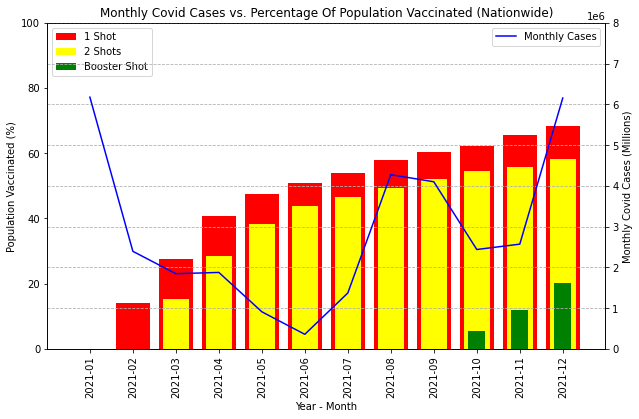

In [18]:
# Create a line and bar chart based on the monthly covid cases and % of people vaccinated
fig, ax1 = plt.subplots()
plt.rcParams["figure.figsize"]=[10,6]
ax1.set_xlabel("Year - Month")
ax1.tick_params(axis = "x", labelrotation = 90)
ax1.set_ylabel("Population Vaccinated (%)")
ax1.bar(final_monthly_set3_df["Year-Month"], final_monthly_set3_df["%_Pops w/ 1_Vaccine_Shot"], color = "red",
        label = "1 Shot", width= 0.8)
ax1.bar(final_monthly_set3_df["Year-Month"], final_monthly_set3_df["%_Pops w/ 2_Vaccine_Shots"], color = "yellow",
        label = "2 Shots", width= 0.6)
ax1.bar(final_monthly_set3_df["Year-Month"], final_monthly_set3_df["%_Pops w/ Booster_Shot"], color = "green",
        label = "Booster Shot", width= 0.4)
ax1.set_ylim([0, 100])
ax1.legend(loc = "upper left")

ax2 = ax1.twinx()
ax2.plot(final_monthly_set3_df["Year-Month"], final_monthly_set3_df["Monthly Cases"], color = "blue", 
         label = "Monthly Cases")
ax2.set_ylabel("Monthly Covid Cases (Millions)")
ax2.legend(loc = "upper right")
ax2.set_ylim([0, 8000000])
plt.grid(linestyle = '--')
plt.title("Monthly Covid Cases vs. Percentage Of Population Vaccinated (Nationwide)")
plt.savefig("Images/MonthlyCases_vs_PerVaccinated.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True, 
            facecolor ="w",
            edgecolor ="b",
            orientation ="landscape")
plt.show()

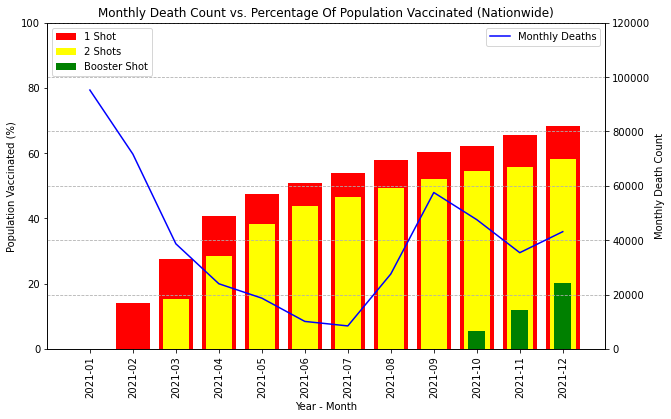

In [19]:
# Create a line and bar chart based on the monthly death counts and % of people vaccinated
fig, ax1 = plt.subplots()
plt.rcParams["figure.figsize"]=[10,6]
ax1.set_xlabel("Year - Month")
ax1.tick_params(axis = "x", labelrotation = 90)
ax1.set_ylabel("Population Vaccinated (%)")
ax1.bar(final_monthly_set3_df["Year-Month"], final_monthly_set3_df["%_Pops w/ 1_Vaccine_Shot"], color = "red",
        label = "1 Shot", width= 0.8)
ax1.bar(final_monthly_set3_df["Year-Month"], final_monthly_set3_df["%_Pops w/ 2_Vaccine_Shots"], color = "yellow",
        label = "2 Shots", width= 0.6)
ax1.bar(final_monthly_set3_df["Year-Month"], final_monthly_set3_df["%_Pops w/ Booster_Shot"], color = "green",
        label = "Booster Shot", width= 0.4)
ax1.set_ylim([0, 100])
ax1.legend(loc = "upper left")

ax2 = ax1.twinx()
ax2.plot(final_monthly_set3_df["Year-Month"], final_monthly_set3_df["Monthly Deaths"], color = "blue", 
         label = "Monthly Deaths")
ax2.set_ylabel("Monthly Death Count")
ax2.legend(loc = "upper right")
ax2.set_ylim([0, 120000])
plt.grid(linestyle = '--')
plt.title("Monthly Death Count vs. Percentage Of Population Vaccinated (Nationwide)")
plt.savefig("Images/MonthlyDeaths_vs_PerVaccinated.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ="b",
            orientation ="landscape")
plt.show()

The Pearson correlation coefficient is (-0.10009194245787345, 0.7569407682653506)
The r value is:-0.10009194245787338


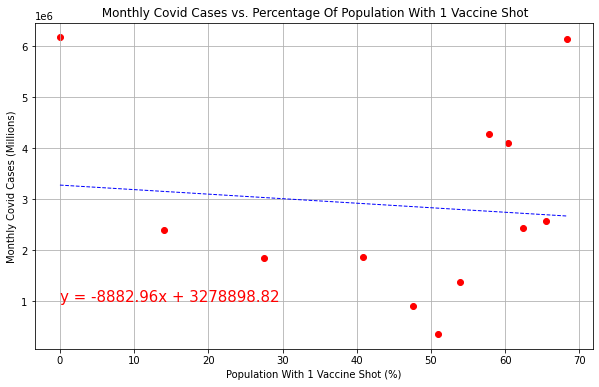

In [20]:
# Calculate the Pearson correlation coefficient between Monthly Covid Cases and % Population with 1 Vaccine Shot
value_correlation = st.pearsonr(final_monthly_set3_df["%_Pops w/ 1_Vaccine_Shot"], final_monthly_set3_df["Monthly Cases"])
print(f"The Pearson correlation coefficient is {value_correlation}")

percent_1shot = final_monthly_set3_df["%_Pops w/ 1_Vaccine_Shot"].tolist()
cases_count = final_monthly_set3_df["Monthly Cases"].tolist()

# Perform a linear regression on Monthly Death Counts vs. % Population with 1 Vaccine Shot
slope, int, r, p, std_err = st.linregress(percent_1shot, cases_count)
# Create equation of line
fit = slope * final_monthly_set3_df["%_Pops w/ 1_Vaccine_Shot"] + int
print(f"The r value is:{r}")

# Plot the linear model on top of scatter plot
plt.scatter(final_monthly_set3_df["%_Pops w/ 1_Vaccine_Shot"], final_monthly_set3_df["Monthly Cases"], color = "red")
plt.plot(final_monthly_set3_df["%_Pops w/ 1_Vaccine_Shot"], fit, "b--", linewidth = 1)
plt.title(f" Monthly Covid Cases vs. Percentage Of Population With 1 Vaccine Shot")
plt.xlabel("Population With 1 Vaccine Shot (%)")
plt.ylabel("Monthly Covid Cases (Millions)")
plt.grid()
# Add equation line
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(int,2))
plt.annotate(line_eq,(0,1000000), fontsize = 15, color = "red")
plt.savefig("Images/MonthlyCases_vs_1shot.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ="b",
            orientation ="landscape")
plt.show()

The Pearson correlation coefficient is (-0.0352351192988746, 0.9134319512019654)
The r value is:-0.03523511929887461


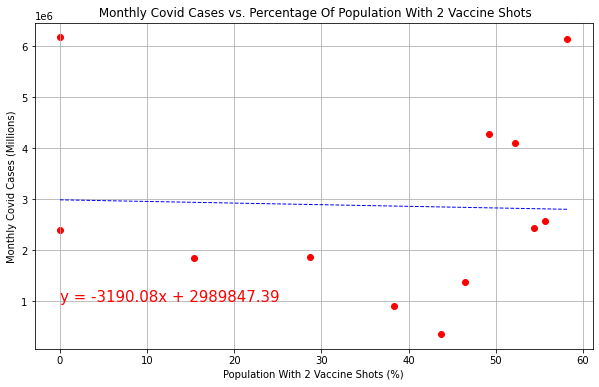

In [21]:
# Calculate the Pearson correlation coefficient between Monthly Covid Cases and % Population with 2 Vaccine Shots
value_correlation = st.pearsonr(final_monthly_set3_df["%_Pops w/ 2_Vaccine_Shots"], final_monthly_set3_df["Monthly Cases"])
print(f"The Pearson correlation coefficient is {value_correlation}")

percent_2shots = final_monthly_set3_df["%_Pops w/ 2_Vaccine_Shots"].tolist()
cases_count = final_monthly_set3_df["Monthly Cases"].tolist()

# Perform a linear regression on Monthly Death Counts vs. % Population with 2 Vaccine Shots
slope, int, r, p, std_err = st.linregress(percent_2shots, cases_count)
# Create equation of line
fit = slope * final_monthly_set3_df["%_Pops w/ 2_Vaccine_Shots"] + int
print(f"The r value is:{r}")

# Plot the linear model on top of scatter plot
plt.scatter(final_monthly_set3_df["%_Pops w/ 2_Vaccine_Shots"], final_monthly_set3_df["Monthly Cases"], color = "red")
plt.plot(final_monthly_set3_df["%_Pops w/ 2_Vaccine_Shots"], fit, "b--", linewidth = 1)
plt.title(f" Monthly Covid Cases vs. Percentage Of Population With 2 Vaccine Shots")
plt.xlabel("Population With 2 Vaccine Shots (%)")
plt.ylabel("Monthly Covid Cases (Millions)")
plt.grid()
# Add equation line
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(int,2))
plt.annotate(line_eq,(0,1000000), fontsize = 15, color = "red")
plt.savefig("Images/MonthlyCases_vs_2shots.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ="b",
            orientation ="landscape")
plt.show()

The Pearson correlation coefficient is (0.44384597311057045, 0.14834776234234173)
The r value is:0.4438459731105704


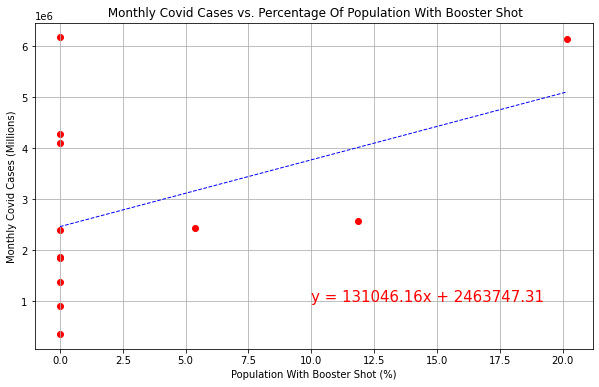

In [22]:
# Calculate the Pearson correlation coefficient between Monthly Covid Cases and % Population with Booster Shot
value_correlation = st.pearsonr(final_monthly_set3_df["%_Pops w/ Booster_Shot"], final_monthly_set3_df["Monthly Cases"])
print(f"The Pearson correlation coefficient is {value_correlation}")

percent_booster = final_monthly_set3_df["%_Pops w/ Booster_Shot"].tolist()
cases_count = final_monthly_set3_df["Monthly Cases"].tolist()

# Perform a linear regression on Monthly Death Counts vs. % Population with Booster Shot
slope, int, r, p, std_err = st.linregress(percent_booster, cases_count)
# Create equation of line
fit = slope * final_monthly_set3_df["%_Pops w/ Booster_Shot"] + int
print(f"The r value is:{r}")

# Plot the linear model on top of scatter plot
plt.scatter(final_monthly_set3_df["%_Pops w/ Booster_Shot"], final_monthly_set3_df["Monthly Cases"], color = "red")
plt.plot(final_monthly_set3_df["%_Pops w/ Booster_Shot"], fit, "b--", linewidth = 1)
plt.title(f" Monthly Covid Cases vs. Percentage Of Population With Booster Shot")
plt.xlabel("Population With Booster Shot (%)")
plt.ylabel("Monthly Covid Cases (Millions)")
plt.grid()
# Add equation line
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(int,2))
plt.annotate(line_eq,(10,1000000), fontsize = 15, color = "red")
plt.savefig("Images/MonthlyCases_vs_Booster.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ="b",
            orientation ="landscape")
plt.show()

The Pearson correlation coefficient is (-0.6058262408663789, 0.036809512030500105)
The r value is:-0.6058262408663787


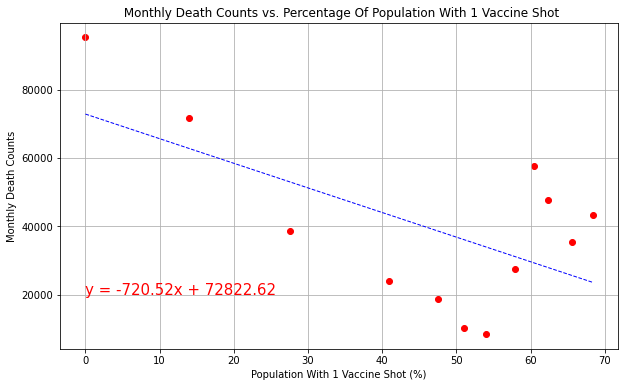

In [23]:
# Calculate the Pearson correlation coefficient between Monthly Death Counts and % Population with 1 Vaccine Shot
value_correlation = st.pearsonr(final_monthly_set3_df["%_Pops w/ 1_Vaccine_Shot"], final_monthly_set3_df["Monthly Deaths"])
print(f"The Pearson correlation coefficient is {value_correlation}")

percent_1shot = final_monthly_set3_df["%_Pops w/ 1_Vaccine_Shot"].tolist()
death_count = final_monthly_set3_df["Monthly Deaths"].tolist()

# Perform a linear regression on Monthly Death Counts vs. % Population with 1 Vaccine Shot
slope, int, r, p, std_err = st.linregress(percent_1shot, death_count)
# Create equation of line
fit = slope * final_monthly_set3_df["%_Pops w/ 1_Vaccine_Shot"] + int
print(f"The r value is:{r}")

# Plot the linear model on top of scatter plot
plt.scatter(final_monthly_set3_df["%_Pops w/ 1_Vaccine_Shot"], final_monthly_set3_df["Monthly Deaths"], color = "red")
plt.plot(final_monthly_set3_df["%_Pops w/ 1_Vaccine_Shot"], fit, "b--", linewidth = 1)
plt.title(f" Monthly Death Counts vs. Percentage Of Population With 1 Vaccine Shot")
plt.xlabel("Population With 1 Vaccine Shot (%)")
plt.ylabel("Monthly Death Counts")
plt.grid()
# Add equation line
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(int,2))
plt.annotate(line_eq,(0,20000), fontsize = 15, color = "red")
plt.savefig("Images/MonthlyDeaths_vs_1shot.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ="b",
            orientation ="landscape")
plt.show()

The Pearson correlation coefficient is (-0.5652830412587208, 0.055446810154035166)
The r value is:-0.5652830412587208


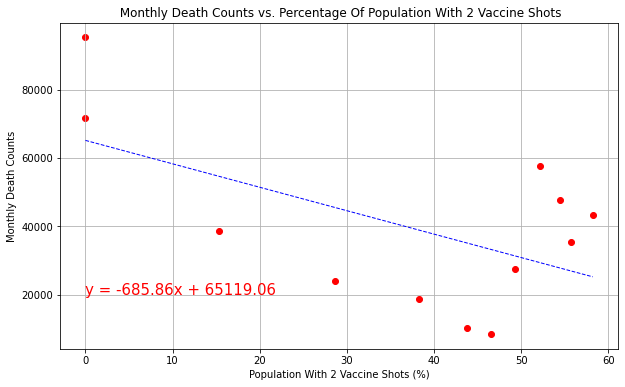

In [24]:
# Calculate the Pearson correlation coefficient between Monthly Death Counts and % Population with 2 Vaccine Shots
value_correlation = st.pearsonr(final_monthly_set3_df["%_Pops w/ 2_Vaccine_Shots"], final_monthly_set3_df["Monthly Deaths"])
print(f"The Pearson correlation coefficient is {value_correlation}")

percent_2shots = final_monthly_set3_df["%_Pops w/ 2_Vaccine_Shots"].tolist()
death_count = final_monthly_set3_df["Monthly Deaths"].tolist()

# Perform a linear regression on Monthly Death Counts vs. % Population with 2 Vaccine Shots
slope, int, r, p, std_err = st.linregress(percent_2shots, death_count)
# Create equation of line
fit = slope * final_monthly_set3_df["%_Pops w/ 2_Vaccine_Shots"] + int
print(f"The r value is:{r}")

# Plot the linear model on top of scatter plot
plt.scatter(final_monthly_set3_df["%_Pops w/ 2_Vaccine_Shots"], final_monthly_set3_df["Monthly Deaths"], color = "red")
plt.plot(final_monthly_set3_df["%_Pops w/ 2_Vaccine_Shots"], fit, "b--", linewidth = 1)
plt.title(f" Monthly Death Counts vs. Percentage Of Population With 2 Vaccine Shots")
plt.xlabel("Population With 2 Vaccine Shots (%)")
plt.ylabel("Monthly Death Counts")
plt.grid()
# Add equation line
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(int,2))
plt.annotate(line_eq,(0,20000), fontsize = 15, color = "red")
plt.savefig("Images/MonthlyDeaths_vs_2shots.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ="b",
            orientation ="landscape")
plt.show()

The Pearson correlation coefficient is (0.03043613058528913, 0.9251910218287336)
The r value is:0.030436130585289125


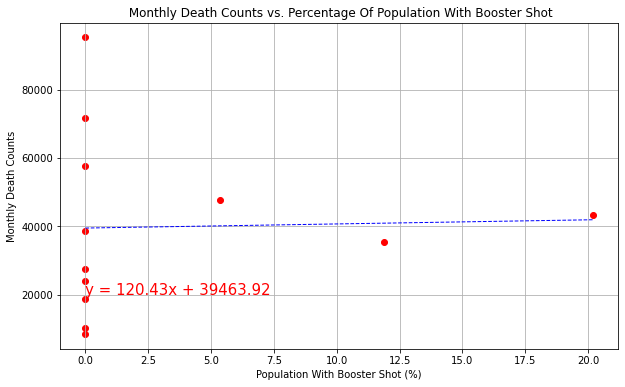

In [25]:
# Calculate the Pearson correlation coefficient between Monthly Death Counts and % Population with Booster Shot
value_correlation = st.pearsonr(final_monthly_set3_df["%_Pops w/ Booster_Shot"], final_monthly_set3_df["Monthly Deaths"])
print(f"The Pearson correlation coefficient is {value_correlation}")

percent_booster = final_monthly_set3_df["%_Pops w/ Booster_Shot"].tolist()
death_count = final_monthly_set3_df["Monthly Deaths"].tolist()

# Perform a linear regression on Monthly Death Counts vs. % Population with Booster Shot
slope, int, r, p, std_err = st.linregress(percent_booster, death_count)
# Create equation of line
fit = slope * final_monthly_set3_df["%_Pops w/ Booster_Shot"] + int
print(f"The r value is:{r}")

# Plot the linear model on top of scatter plot
plt.scatter(final_monthly_set3_df["%_Pops w/ Booster_Shot"], final_monthly_set3_df["Monthly Deaths"], color = "red")
plt.plot(final_monthly_set3_df["%_Pops w/ Booster_Shot"], fit, "b--", linewidth = 1)
plt.title(f" Monthly Death Counts vs. Percentage Of Population With Booster Shot")
plt.xlabel("Population With Booster Shot (%)")
plt.ylabel("Monthly Death Counts")
plt.grid()
# Add equation line
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(int,2))
plt.annotate(line_eq,(0,20000), fontsize = 15, color = "red")
plt.savefig("Images/MonthlyDeaths_vs_Booster.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ="b",
            orientation ="landscape")
plt.show()